In [1]:
# Imports and environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc

In [2]:
df_train = pd.read_csv("../data/transformed_train.csv")
df_test = pd.read_csv("../data/transformed_test.csv")

In [3]:
# Separate our features (X) and target (y)
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80% Train - 20% Validation
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (267700, 22)
train_y shape: (267700, 1)
val_X shape: (66926, 22)
val_y shape: (66926, 1)


In [4]:
clfs = dict()

In [5]:
cv = KFold(
    n_splits=4,     # Each fold is 20% of df_X
    shuffle=True,
    random_state=0  # Reproducible result
)

In [6]:
clf = LogisticRegression(
    solver="saga",    
    class_weight="balanced",
    max_iter=1000,
    random_state=0            # Reproducible result
)

In [7]:
params = {
    "C": 1 / np.logspace(-5, 2, num=100),
    "penalty": ["l1", "l2"]
}

In [8]:
grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["logistic1"] = grid_clf

In [9]:
grid_clf.best_params_

{'penalty': 'l1', 'C': 0.07054802310718646}

In [10]:
# Degree 2 Polynomial Features:
poly = PolynomialFeatures(2)
train_X_poly2 = poly.fit_transform(train_X)
val_X_poly2 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly2 = scaler.fit_transform(train_X_poly2)
val_X_poly2 = scaler.transform(val_X_poly2)

train_X_poly2 = train_X_poly2.astype('float32')
val_X_poly2 = val_X_poly2.astype('float32')

In [11]:
grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X_poly2, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X_poly2)
val_pred_y = grid_clf.predict(val_X_poly2)
clfs["logistic2"] = grid_clf

In [12]:
grid_clf.best_params_

{'penalty': 'l2', 'C': 0.031257158496882355}

In [14]:
# Degree 3 Polynomial Features:
poly = PolynomialFeatures(3)
train_X_poly3 = poly.fit_transform(train_X)
val_X_poly3 = poly.transform(val_X)

# We need to scale the data again after transforming it to polynomial features
scaler = StandardScaler()
train_X_poly3 = scaler.fit_transform(train_X_poly3)
val_X_poly3 = scaler.transform(val_X_poly3)

train_X_poly3 = train_X_poly3.astype('float32')
val_X_poly3 = val_X_poly3.astype('float32')

MemoryError: Unable to allocate 4.59 GiB for an array with shape (267700, 2300) and data type float64

In [ ]:
grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X_poly3, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X_poly3)
val_pred_y = grid_clf.predict(val_X_poly3)
clfs["logistic3"] = grid_clf

In [ ]:
grid_clf.best_params_

In [15]:
params = {
    "max_depth": np.arange(2, 24, 2),
    "min_samples_split": np.arange(2, 10, 2),
}

In [16]:
clf = DecisionTreeClassifier(
    criterion="gini",         # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0            # Reproducible result
)

grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["tree"] = grid_clf

In [17]:
grid_clf.best_params_

{'min_samples_split': 4, 'max_depth': 22}

In [18]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
}

In [19]:
clf = BaggingClassifier(
    estimator=clfs["tree"],
    random_state=0  # Reproducible result
)

grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["bagged_trees"] = grid_clf

MemoryError: Unable to allocate 33.7 MiB for an array with shape (22, 200775) and data type float64

In [ ]:
grid_clf.best_params_

In [ ]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_samples": np.arange(0.1, 1.0, 0.1),
    "max_features": [0.5, 0.7, 0.9],  # Specify different fractions of features to consider for each base estimator
}

In [ ]:
clf = BaggingClassifier(estimator=clfs["tree"], random_state=0, bootstrap_features=True)

# Perform grid search to tune hyperparameters
grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)

# Store the trained model in the clfs dictionary
clfs["feature_bagged_trees"] = grid_clf

In [ ]:
grid_clf.best_params_

In [20]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
}

In [21]:
clf = RandomForestClassifier(
    criterion="gini",  # Good for balanced data (we have already up-sampled out data so it is now balanced)
    class_weight="balanced",
    random_state=0     # Reproducible result
)

grid_clf = RandomizedSearchCV(clf, params, cv=cv, n_jobs=-1, scoring=["f1", "roc_auc"], refit="f1", return_train_score=True)
grid_clf.fit(train_X, train_y.values.ravel())

train_pred_y = grid_clf.predict(train_X)
val_pred_y = grid_clf.predict(val_X)
clfs["forest"] = grid_clf

MemoryError: Unable to allocate 11.2 MiB for an array with shape (22, 66925) and data type float64

Model                 AUC        F1
-----------------------------------
logistic1         0.94896   0.87614
logistic2         0.95498   0.88838
tree              0.97949   0.96754


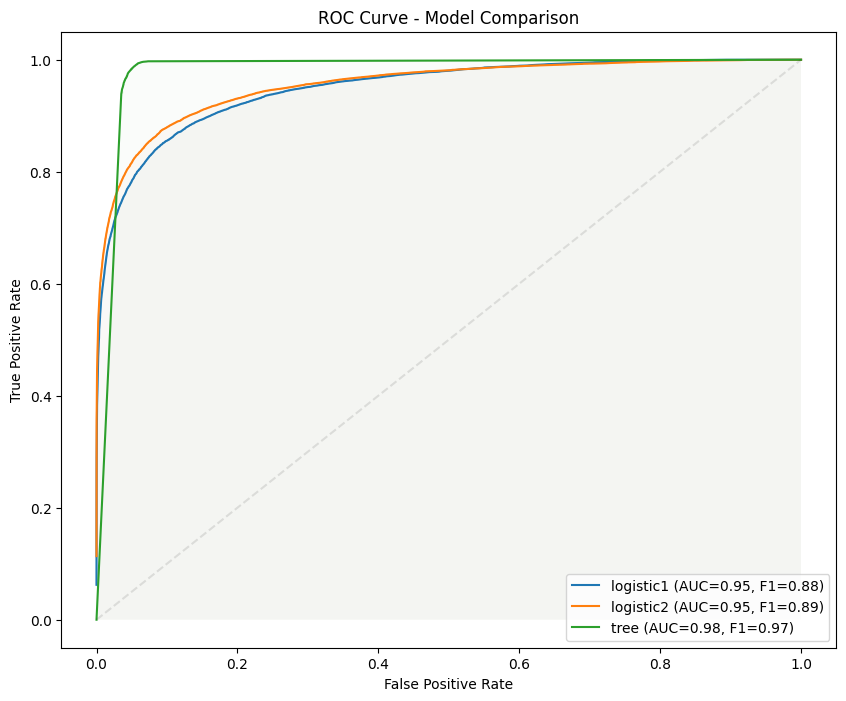

In [22]:
fig, axis = plt.subplots(figsize=(10, 8))

print(f"{'Model':15}{'AUC':>10}{'F1':>10}")
print("-" * 35)
for name, clf in clfs.items():
    if name == "logistic2":
        prob_y = clf.predict_proba(val_X_poly2)[:, 1]
        pred_y = clf.predict(val_X_poly2)
    elif name == "logistic3":
        prob_y = clf.predict_proba(val_X_poly3)[:, 1]
        pred_y = clf.predict(val_X_poly3)
    elif name == "logistic4":
        prob_y = clf.predict_proba(val_X_poly4)[:, 1]
        pred_y = clf.predict(val_X_poly4)
    else:
        prob_y = clf.predict_proba(val_X)[:, 1]
        pred_y = clf.predict(val_X)

    fpr, tpr, thresholds = roc_curve(val_y, prob_y)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(x=fpr, y=tpr, label=f"{name} (AUC={roc_auc:.2f}, F1={f1_score(val_y, pred_y):.2f})", ax=axis)
    plt.fill_between(fpr, tpr, alpha=0.024)
    print(f"{name:15}{roc_auc:10.5f}{f1_score(val_y, pred_y):10.5f}")


plt.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.1)
axis.set_xlabel("False Positive Rate")
axis.set_ylabel("True Positive Rate")
axis.set_title("ROC Curve - Model Comparison")
axis.legend()

plt.show()
fig.savefig("../images/ModelDev_ROC_AUC_Compare.png", dpi=300)